MNIST DATASET NUM RECOGNITION BY HANDWRITTEN

In [57]:
import gzip
import os
from os.path import isfile, join
import numpy as np #sirve para manejar arreglos muy grandes

In [58]:
#for f in list_files(mnist_path):print(f)
#verifico que mi metodo funcione, y me muestre los archivos
#deseados

In [59]:
mnist_path='mnist_r'

def list_files(mnist_path):
    return [join(mnist_path,f) for f in os.listdir(mnist_path) if isfile(join(mnist_path, f))]

def get_images(mnist_path):
    #x_train, y_train, x_test, y_test = None, None, None, None 
    for f in list_files(mnist_path):
        if 'train-images' in f:
            with gzip.open(f, 'rb') as data:
                _ = int.from_bytes(data.read(4), 'big')
                num_images = int.from_bytes(data.read(4), 'big')
                rows = int.from_bytes(data.read(4), 'big')
                cols = int.from_bytes(data.read(4), 'big')
                train_images = data.read()
                x_train = np.frombuffer(train_images, dtype=np.uint8)
                x_train = x_train.reshape((num_images, rows, cols))
        elif 'train-labels' in f:
            with gzip.open(f, 'rb') as data:
                train_labels = data.read()[8:]
                y_train = np.frombuffer(train_labels, dtype=np.uint8)
        if 't10k-images' in f:
            with gzip.open(f, 'rb') as data:
                _ = int.from_bytes(data.read(4), 'big')
                num_images = int.from_bytes(data.read(4), 'big')
                rows = int.from_bytes(data.read(4), 'big')
                cols = int.from_bytes(data.read(4), 'big')
                test_images = data.read()
                x_test = np.frombuffer(test_images, dtype=np.uint8)
                x_test = x_test.reshape((num_images, rows, cols))
        elif 't10k-labels' in f:
            with gzip.open(f, 'rb') as data:
                test_labels = data.read()[8:]
                y_test = np.frombuffer(test_labels, dtype=np.uint8)
    
    return x_train, y_train, x_test, y_test

In [60]:
for f in list_files(mnist_path):print(f)
#verifico que mi metodo funcione, y me muestre los archivos
#deseados

mnist_r\t10k-images-idx3-ubyte.gz
mnist_r\t10k-labels-idx1-ubyte.gz
mnist_r\train-images-idx3-ubyte.gz
mnist_r\train-labels-idx1-ubyte.gz


In [61]:
x_train_num, y_train_num, x_test_num, y_test_num=get_images(mnist_path)

verificamos que cada variable a suar tenga las dimesiones que se han establecido en el database

In [62]:
print(x_train_num.shape)
print(y_train_num.shape)
print(x_test_num.shape)
print(y_test_num.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [63]:
from jupyterthemes import jtplot
jtplot.style(grid=False)

In [64]:
import matplotlib.pyplot as plt #graficas
%matplotlib inline
#graficas dentro de la libreta de jupyter

Ahora sí, red neuronal de 2 capas!!
lo anterior sólo lee los archivos binarios para convertirlos en arreglos numpy (eso se puede resumir en 2 líneas, pero hay que aprender)

Convertir imagene en vectore y en float32

In [65]:
x_train = x_train_num[:50000].reshape(50000, -1).astype(np.float32)/255
y_train = y_train_num[:50000].reshape(50000, 1)
#[:50000] sólo extrae los primeros 500000 elementos
#reshape es reagruparto en 50000 filas, y en -1 columnas(28*28)
#astype es convertirlo en flotante y el /255 para el rango entre 0-1

x_val = x_train_num[50000:].reshape(10000, -1).astype(np.float32)/255
y_val = y_train_num[50000:].reshape(10000, 1)
'''x_val va a almacenar los 10000 datos restantes, es por ello
que [50000:] dando a entender que los los datos después del 50000
y se usará coo validación'''
x_test = x_test_num.copy().reshape(10000, -1).astype(np.float32)/255
y_test = y_test_num.copy().reshape(10000, 1)
'''el .copy() hace una copia literal del arreglo x_test_num'''

'el .copy() hace una copia literal del arreglo x_test_num'

In [66]:
print(x_train.max())
#miramos el valor máximo del dataset

1.0


MIRAMOS LAS FORMAS (X,Y)

In [67]:
print(x_train.shape) #shape (50000, 784)
print(y_train.shape) #shape (50000, 1)

print(x_val.shape)
print(y_val.shape)

print(x_test.shape)
print(y_test.shape)

(50000, 784)
(50000, 1)
(10000, 784)
(10000, 1)
(10000, 784)
(10000, 1)


graficar imagenes

In [68]:
def plot_number(image):
    plt.imshow(image.squeeze(), cmap=plt.get_cmap('gray'))
    plt.axis('off')
    plt.show() #.show() permite mostrar la imagen

La imagen mostrada es un: [2]


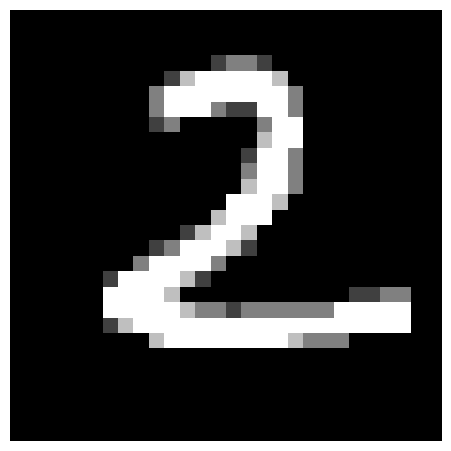

In [69]:
rnd_idx = np.random.randint(len(y_test))
print(f'La imagen mostrada es un: {y_test[rnd_idx]}')
plot_number(x_test_num[rnd_idx])

RED NEURONAL 2 CAPAS

CREAR MINI-BATCHES
minibatches es dividir los datos de entrada en grupos más pequeños para que no consuman tanta memoria (el # de grupos preferiblemente en potencias de 2)

In [71]:
def create_minibatches(mb_size, x, y, shuffle = True):
    '''
    x  #muestras, 784
    y #muestras, 1
    '''
    assert x.shape[0] == y.shape[0], 'Error en cantidad de muestras'
    total_data = x.shape[0]
    if shuffle: 
        idxs = np.arange(total_data)
        np.random.shuffle(idxs)
        x = x[idxs]
        y = y[idxs]
        
    return ((x[i:i+mb_size], y[i:i+mb_size]) for i in range(0, total_data, mb_size))

explicación de código
create_minibatches(
    mb_size=numero de elementos en cada minibatch
    x=imagenes o total a etrenar
    y=etiquetas a entrenar
    shuffle=bandera para un muestreo aleatorio
)
x.shape[0] nos da el número total de lo ELEMENTOS, NO SUS DIMENSIONES
assert=funcion en python que se utiliza para segurarse de que una expresion sea verdadera

Parametros iniciales

In [72]:
def init_parameters(input_size, neurons):
    
    '''
    input_size -> elementos de entrada, 784
    neurons -> list [200(primera capa), 10(segunda capa)] 
    con cantidad de neuronas en cada capa
    '''
    
    W1 = np.random.randn(neurons[0], input_size) * 0.001
    b1 = np.zeros((neurons[0], 1))
    
    W2 = np.random.randn(neurons[1], neurons[0]) * 0.001
    b2 = np.zeros((neurons[1], 1))
    
    return {'W1': W1, 'b1':b1, 'W2':W2, 'b2':b2}

el init_parameters está bien si sólo usamos 2 capas, pero si estamos hablando de más capas, lo mejor es usar las técnicas xavier o kaiming he
en dato caso de que neurons sea de [200,10]
neurons[0]=200
neurons[1]=10
cabe resaltar que W1 o W2 son los valores entre las conexiones de neuronas, y se dan por el arreglo [#neuronas de salida, #neuronas de entrada]

In [73]:
parameters = init_parameters(28*28, [200, 10])
print(parameters['W1'].shape)
print(parameters['W2'].shape)
print(parameters['b1'].shape)
print(parameters['b2'].shape)


(200, 784)
(10, 200)
(200, 1)
(10, 1)


In [74]:
def relu(x):
    return np.maximum(0, x)

np.maximum(0,x) sirve para hallar el número mayor, sabemos que el RELU funciona entre 0-1, por lo que, si x es un número negativo, se corta y lo hace igual a 0
x=z

In [75]:
def score(x, parameters, activation_fcn):
    '''
    x tiene la forma (#pixeles, num samples)
    '''
    z1 = parameters['W1'] @ x + parameters['b1']
    a1 = activation_fcn(z1) # devuel fcn. de activa.
    z2 = parameters['W2'] @ a1 + parameters['b2']
    
    return z2, z1, a1

el metodo scores, realiza las operaciones entre capas

In [76]:
scores,z1, a1 = score(x_train[:64].T, parameters, relu) 

In [77]:
x_train[:64].T.shape

(784, 64)

.T nos devuelve las dimensiones transpuestas, es decir, cambiar las filas por columnas y viceversa, veamos el ejemplo:
esto se debe a sus dimensiones W[200,784] y x_train[64,784]
por lo que NO SE PUEDEN MULTIPLICAR, POR ESO SE USA LA TRANSPUESTA
(mirar la diferencia arriba y abajo)

In [78]:
x_train[:64].shape

(64, 784)

In [79]:
scores.shape

(10, 64)

In [80]:
def softmax(x):
    exp_scores = np.exp(x)
    sum_exp_scores = np.sum(exp_scores, axis=0)
    probs = exp_scores/sum_exp_scores
    return probs

exp_scores es E elevado a z2(o el último score) (E=euler)
axis = 0 es que se sume de manera vertical


In [81]:
def x_entropy(scores, y, batch_size=64):
    probs = softmax(scores)
    y_hat = probs[y.squeeze(), np.arange(batch_size)]
    cost = np.sum(-np.log(y_hat)) / batch_size
    
    return probs, cost

x_entropy es la funcion de pérdida 
y=y_train
--ahora, el squeeze lo que hace es que sólo nos de los datos de las filas (x,y sólo pase los valores de x)(elimine un eje)
--el .arrange sirve para seleccionar todas las columnas, es decir, np.arrange(64) da un output de un arrego de 0-64
--np.sum() devuelve una suma acumulada de los valores de un array

In [82]:
def backward(probs, x, y, z1, a1, scores, parameters, batch_size=64):
    grads = {}
    probs[y.squeeze(), np.arange(batch_size)] -= 1 # y-hat - y
    dz2 = probs.copy()
    
    dW2 = dz2 @ a1.T / batch_size
    db2 = np.sum(dz2, axis =1, keepdims=True) / batch_size
    da1 = parameters['W2'].T @ dz2
    
    dz1 = da1.copy()
    dz1[z1 <= 0 ] =0
    
    dW1 = dz1 @ x 
    db1 = np.sum(dz1, axis=1, keepdims=True) 
    
    assert parameters['W1'].shape == dW1.shape, 'W1 no igual forma'
    assert parameters['W2'].shape == dW2.shape, 'W2 no igual forma'
    assert parameters['b1'].shape == db1.shape, 'b1 no igual forma'
    assert parameters['b2'].shape == db2.shape, 'b2 no igual forma'
    
    grads = {'w1':dW1,  'b1':db1, 'W2':dW2, 'b2':db2}
    
    return grads
    

______

In [83]:
y_hat, cost = x_entropy(scores, y_train[:64])

In [84]:
y_hat.shape

(10, 64)

In [85]:
print(cost)

2.3025885614107926


In [86]:
grads = backward(y_hat, x_train[:64], y_train[:64],z1, a1, scores, parameters)

In [87]:
def accuracy(x_data, y_data, mb_size=64):
    correct = 0
    total = 0
    for i, (x, y) in enumerate(create_minibatches(mb_size, x_data, y_data)):
        scores2, z1, a1 = score(x.T, parameters, relu)
        y_hat, cost = x_entropy(scores2, y, batch_size=len(x))
        
        correct += np.sum(np.argmax(y_hat, axis=0) == y.squeeze())
        total += y_hat.shape[1]
    return correct/total

In [88]:
def train(epochs, parameters, mb_size=64, learning_rate = 1e-3):
    for epoch in range(epochs):
        for i, (x, y) in enumerate(create_minibatches(mb_size, x_train, y_train)):
            scores2, z1, a1 = score(x.T, parameters=parameters, activation_fcn=relu)
            y_hat, cost = x_entropy(scores2, y, batch_size=len(x))
            grads = backward(y_hat, x, y, z1, a1, scores2, parameters, batch_size=len(x))
            
            parameters['W1'] = parameters['W1'] - learning_rate*grads['w1']
            parameters['b1'] = parameters['b1'] - learning_rate*grads['b1']
            parameters['b2'] = parameters['b2'] - learning_rate*grads['b2']
            parameters['W2'] = parameters['W2'] - learning_rate*grads['W2']
            
        print(f'costo es: {cost}, y accuracy: {accuracy(x_val, y_val, mb_size)}')
    return parameters
    

In [89]:
mb_size = 512
learning_rate = 1e-2
epochs = 20
parameters = train(epochs=epochs, parameters=parameters, mb_size=mb_size, learning_rate=learning_rate)

costo es: 0.5248895794399979, y accuracy: 0.8724
costo es: 0.4605386277336663, y accuracy: 0.8986
costo es: 0.44001018323179814, y accuracy: 0.9128
costo es: 0.33243804774244917, y accuracy: 0.9223
costo es: 0.29132922259268657, y accuracy: 0.9271
costo es: 0.2463021535520077, y accuracy: 0.933
costo es: 0.24396570016925717, y accuracy: 0.9413
costo es: 0.16744781807292677, y accuracy: 0.9452
costo es: 0.1710459772161871, y accuracy: 0.9491
costo es: 0.16150029707596442, y accuracy: 0.952
costo es: 0.1459179973123147, y accuracy: 0.9552
costo es: 0.18726482319105447, y accuracy: 0.9557
costo es: 0.208182840434081, y accuracy: 0.9582
costo es: 0.13651632962431084, y accuracy: 0.9598
costo es: 0.1451474739421697, y accuracy: 0.961
costo es: 0.1212283016473773, y accuracy: 0.9624
costo es: 0.13456670783989533, y accuracy: 0.9639
costo es: 0.08672845069203425, y accuracy: 0.9642
costo es: 0.12295100750338242, y accuracy: 0.9653
costo es: 0.07612795302898392, y accuracy: 0.9665


In [90]:
accuracy(x_train, y_train, mb_size)

0.97044

In [91]:
accuracy(x_test, y_test, mb_size)

0.9654

In [95]:
def predict(x):
    scores2, _, _ = score(x, parameters, relu)
    return np.argmax(scores2)

In [93]:
x_test[0].reshape(-1, 1).shape

(784, 1)

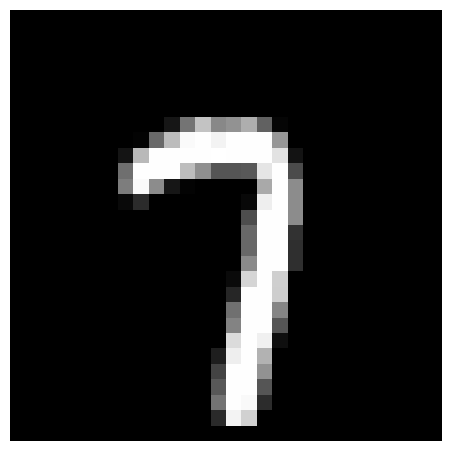

el valor predicho es: 7


In [100]:
idx = np.random.randint(len(y_test))
plot_number(x_test_num[idx])
pred = predict(x_test[idx].reshape(-1, 1))
print(f'el valor predicho es: {pred}')